In [ ]:
%pip install -q open_clip_torch

In [2]:
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


In [3]:
from os.path import join
from datetime import datetime
import math

from rastervision.pipeline.file_system.utils import json_to_file, file_to_json
from rastervision.core import Box, RasterStats
from rastervision.core.data import (
    RasterioCRSTransformer, MultiRasterSource, Scene, StatsTransformer, XarraySource)
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.aws_s3 import S3FileSystem
from rastervision.pytorch_learner import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader
import pystac_client
import stackstac
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

---

# Load model

In [4]:
bands = [
    'red',
    'green',
    'blue',
]

In [5]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)
ckpt_path = '../queryable-earth/data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location=DEVICE)['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.cuda().eval()
print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [6]:
stats_tf = StatsTransformer.from_stats_json('data/SSL4EO_stats.json')

---

## Find images

In [7]:
bbox = Box(xmin=67.882, ymin=27.674, xmax=67.929, ymax=27.825)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox

Box(ymin=27.674, xmin=67.882, ymax=27.825, xmax=67.929)

In [8]:
URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2017-01-01/2024-04-30',
    query={'eo:cloud_cover': {'lt': 5}},
).item_collection()
len(items)

621

In [9]:
items = items[::-1]

In [10]:
gdf = gpd.GeoDataFrame.from_features(items)

---

### Convert to a Raster Vision `RasterSource`

In [11]:
timestamps = [
    datetime.fromisoformat(item.properties['datetime']) for item in items]
timestamps = np.array(timestamps)

In [12]:
for item in items:
    for asset in item.assets.values():
        asset.href = S3FileSystem.url_to_uri(asset.href)

In [ ]:
bbox_pixel = Box(ymin=1000-6, xmin=6000-6, ymax=1500+6, xmax=6500+6)

raster_sources = [
    MultiRasterSource.from_stac(
        item, 
        assets=bands, 
        bbox=bbox_pixel, 
        channel_order=[0, 1, 2], 
        allow_streaming=True,
        force_same_dtype=True,
        raster_transformers=[stats_tf],
    )
    for item in tqdm(items)
]

In [14]:
stackstac_args = dict(assets=bands, rescale=False, fill_value=0, dtype='float32')

bbox_pixel = Box(ymin=1000-6, xmin=6000-6, ymax=1500+6, xmax=6500+6)

raster_sources2 = [
    XarraySource.from_stac(
        item, 
        bbox=bbox_pixel, 
        allow_streaming=True, 
        raster_transformers=[stats_tf],
        stackstac_args=stackstac_args,
    )
    for item in tqdm(items)
]

  0%|          | 0/621 [00:00<?, ?it/s]

In [15]:
dses = [
    SemanticSegmentationSlidingWindowGeoDataset(
        Scene('', rs),
        size=512,
        stride=512,
        out_size=224,
    ) 
    for rs in tqdm(raster_sources2)
]

  0%|          | 0/621 [00:00<?, ?it/s]

In [16]:
ds = ConcatDataset(dses)
len(ds)

621

In [17]:
dl = DataLoader(ds, batch_size=4, num_workers=4, shuffle=False, pin_memory=True)

---

## Generate embeddings

### Run inference

In [18]:
emb_dims = 768
embeddings = torch.zeros(len(timestamps), emb_dims)

i = 0
with torch.inference_mode(), tqdm(dl, desc='Creating embeddings') as bar:
    for x, _ in bar:
        x = x.to(DEVICE)
        emb = model.encode_image(x).squeeze()
        embeddings[i:i + len(x)] = emb.cpu()
        i += len(x)

Creating embeddings:   0%|          | 0/156 [00:00<?, ?it/s]

In [24]:
window_geom = raster_sources2[0].bbox.to_shapely()
window_geom_map = raster_sources2[0].crs_transformer.pixel_to_map(window_geom)
good_dates_mask = np.array([window_geom_map.within(g) for g in gdf.geometry])
print('# bad', (~good_dates_mask).sum())

# bad 296


In [38]:
embeddings = embeddings[good_dates_mask]
timestamps = timestamps[good_dates_mask]
len(embeddings), len(timestamps)

(325, 325)

In [39]:
embeddings_info = dict(
    embeddings=embeddings, 
    timestamps=timestamps, 
    dates=np.array([str(t.date()) for t in timestamps]), 
)
torch.save(embeddings_info, 'data/embeddings_skyclip_rgb_chip512.pt')

## Analysis

In [63]:
embeddings_info = torch.load('data/embeddings_skyclip_rgb_chip512.pt')
embeddings = embeddings_info['embeddings']
dates = embeddings_info['dates']
embeddings.shape

torch.Size([325, 768])

In [28]:
# N = len(embeddings)
# embeddings = embeddings[np.arange(N) != error.argmax()]
# dates = dates[np.arange(N) != error.argmax()]

In [41]:
embeddings -= embeddings.mean(axis=0)

In [42]:
dates_flood = np.array([
    '2020-07-15', '2020-09-08', '2020-09-18', '2020-09-23',
    '2020-09-28', '2020-10-03', '2020-10-08', '2020-10-18',
    '2020-10-28', '2022-09-03', '2022-09-08', '2022-09-13',
    '2022-09-23', '2022-09-28', '2022-10-03', '2022-10-08',
    '2022-10-13', '2022-10-18', '2022-10-23', '2022-10-28'
])

In [43]:
t_doy = np.array([datetime.strptime(date, '%Y-%m-%d').timetuple().tm_yday for date in dates])
t_doy_flood = np.array([datetime.strptime(date, '%Y-%m-%d').timetuple().tm_yday for date in dates_flood])

t_foy = np.clip(t_doy / 365, 0, 1)

In [44]:
def to_t_day(date):
    timetuple = datetime.strptime(date, '%Y-%m-%d').timetuple()
    year = timetuple.tm_year
    doy = np.clip(timetuple.tm_yday / 365, 0, 1)
    return year + doy

In [45]:
t_day = np.array([to_t_day(date) for date in dates])
t_day_flood = np.array([to_t_day(date) for date in dates_flood])

---

### PCA

In [66]:
train_mask = np.array([date < '2023-07-01' for date in dates])

In [67]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
pca.fit(embeddings[train_mask])
# pca.fit(embeddings)
pca_emb = pca.transform(embeddings)
pca_emb.shape

(325, 297)

### Regression

In [68]:
from sklearn.linear_model import RANSACRegressor
from matplotlib.colors import Normalize

def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

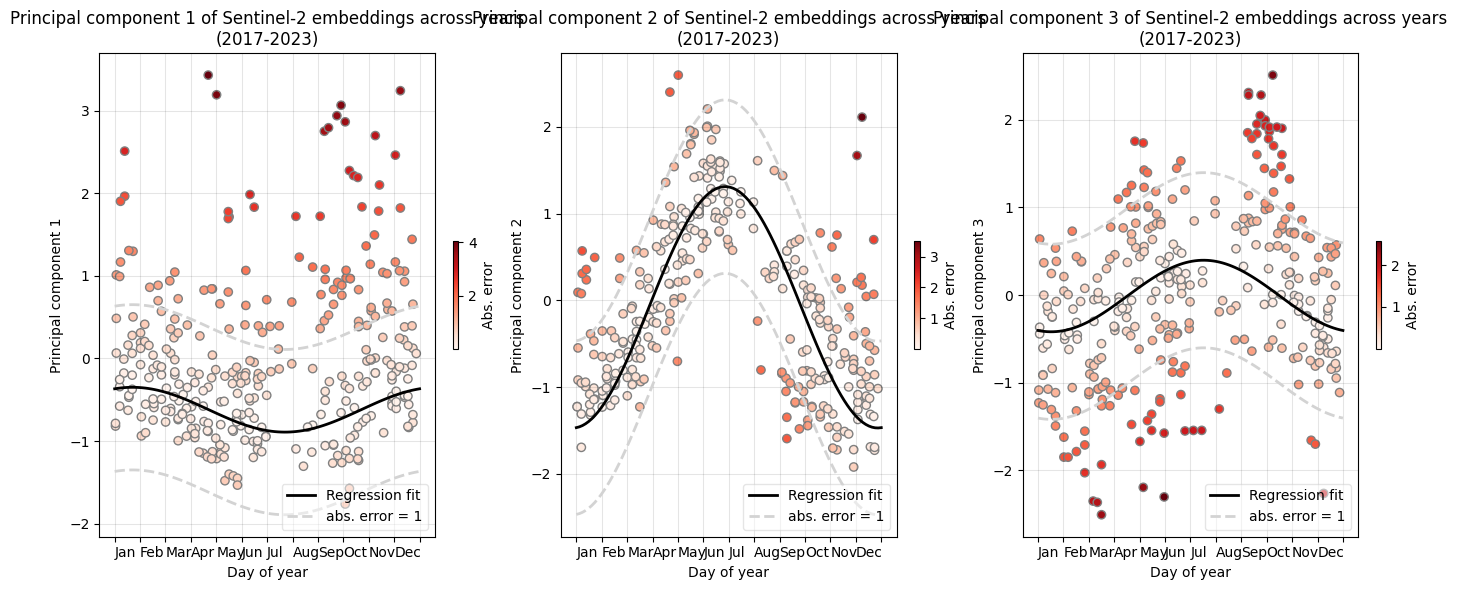

In [69]:
plt.close('all')
fig, axs = plt.subplots(1, 3, figsize=(14, 6), squeeze=True, tight_layout=True)
cmap = plt.get_cmap('Reds')

for pc, ax in enumerate(axs.flat):
    lr = RANSACRegressor()
    Y = pca_emb[:, pc]
    X = t_to_feats(t_foy)
    _ = lr.fit(X, Y)

    x = t_foy
    y_pred = lr.predict(t_to_feats(x))
    error = np.abs(y_pred - pca_emb[:, pc])
    norm = Normalize(error.min(), error.max())
    cols = cmap(norm(error))
    ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

    t = np.linspace(0, 1, 100)
    x = t_to_feats(t)
    y_pred = lr.predict(x)
    ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')
    ax.plot(t, y_pred + 1, lw=2, c='lightgray', ls='--', label='abs. error = 1')
    ax.plot(t, y_pred - 1, lw=2, c='lightgray', ls='--')
    ax.legend(loc='lower left')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.015, label='Abs. error')
    
    ax.legend(loc='lower right', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_xticks(np.arange(0, 13) / 12, 
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 embeddings across years\n(2017-2023)')
    ax.set_xlabel('Day of year')
    ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [50]:
pc = 1
lr = RANSACRegressor()
Y = pca_emb[:, pc]
X = t_to_feats(t_foy)
_ = lr.fit(X, Y)

x = t_foy
y_pred = lr.predict(t_to_feats(x))
error = np.abs(y_pred - pca_emb[:, pc])

dates_flood = dates[(t_foy > 0.5) & (error > 1.)]
dates_flood

array(['2017-11-08', '2017-12-13', '2018-12-08', '2019-10-19',
       '2019-11-08', '2020-08-04', '2020-09-08', '2020-09-08',
       '2020-09-18', '2020-09-18', '2020-09-23', '2020-09-28',
       '2020-09-28', '2020-10-03', '2020-10-03', '2020-10-08',
       '2020-10-08', '2020-10-18', '2020-10-18', '2020-10-28',
       '2020-11-02', '2020-12-07', '2021-11-02', '2021-12-02',
       '2021-12-07', '2021-12-22', '2021-12-22', '2022-09-03',
       '2022-09-08', '2022-09-13', '2022-09-23', '2022-10-03',
       '2022-10-08', '2023-08-09', '2023-09-03', '2023-09-08',
       '2023-09-13', '2023-12-02'], dtype='<U10')

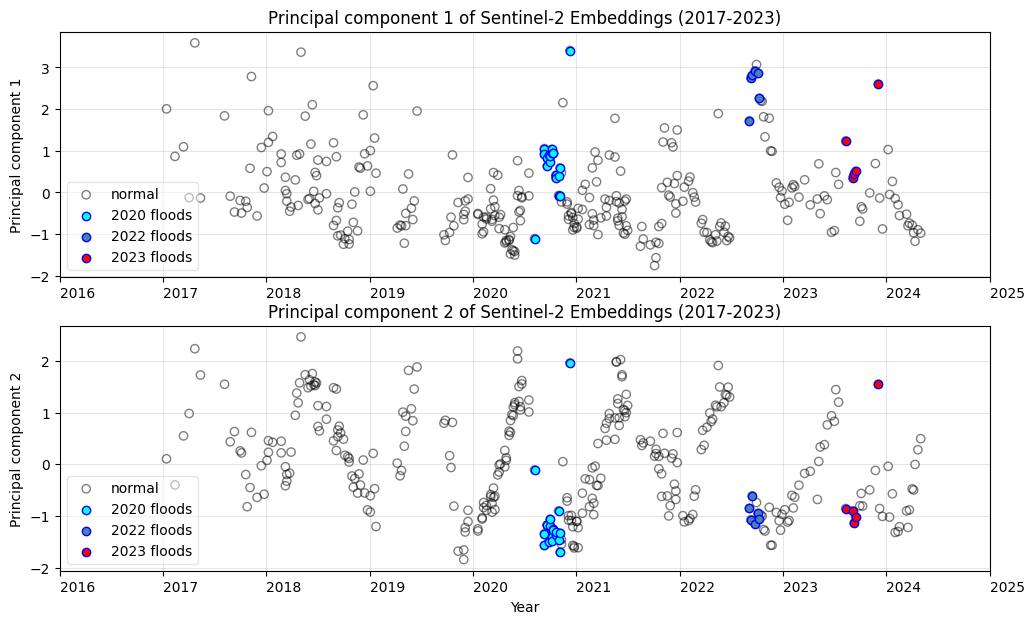

In [51]:
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(12, 7), squeeze=True)

for pc, ax in enumerate(axs):
    ax.scatter(t_day, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
    
    flood_dates_2020 = set([date for date in dates_flood if date.startswith('2020')])
    flood_inds_2020 = np.where([date in flood_dates_2020 for date in dates])[0]
    ax.scatter(t_day[flood_inds_2020], pca_emb[flood_inds_2020, pc], ec='b', fc='cyan', label='2020 floods')
    
    flood_dates_2022 = set([date for date in dates_flood if date.startswith('2022')])
    flood_inds_2022 = np.where([date in flood_dates_2022 for date in dates])[0]
    ax.scatter(t_day[flood_inds_2022], pca_emb[flood_inds_2022, pc], ec='b', fc='steelblue', label='2022 floods')
    
    flood_dates_2023 = set([date for date in dates_flood if date.startswith('2023')])
    flood_mask_2023 = np.array([date in flood_dates_2023 for date in dates])
    ax.scatter(t_day[flood_mask_2023], pca_emb[flood_mask_2023, pc], ec='b', fc='red', label='2023 floods')
    
    ax.legend(loc='lower left', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 Embeddings (2017-2023)')
    ax.set_xlim((2016, 2025))
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_ylabel(f'Principal component {pc + 1}')
    if pc == len(axs) - 1:
        ax.set_xlabel('Year')

plt.show()

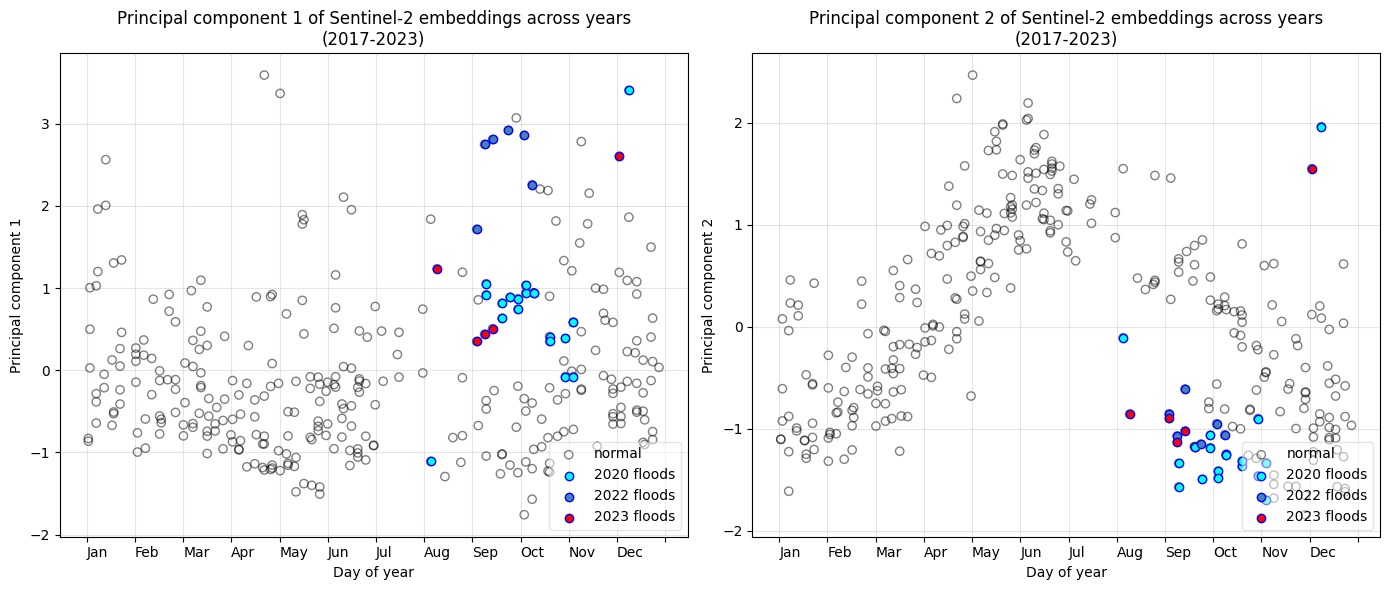

In [52]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(14, 6), squeeze=True, tight_layout=True)

for pc, ax in enumerate(axs.flat):
    ax.scatter(t_foy, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
    
    flood_dates_2020 = set([date for date in dates_flood if date.startswith('2020')])
    flood_mask_2020 = np.array([date in flood_dates_2020 for date in dates])
    ax.scatter(t_foy[flood_mask_2020], pca_emb[flood_mask_2020, pc], ec='b', fc='cyan', label='2020 floods')
    
    flood_dates_2022 = set([date for date in dates_flood if date.startswith('2022')])
    flood_mask_2022 = np.array([date in flood_dates_2022 for date in dates])
    ax.scatter(t_foy[flood_mask_2022], pca_emb[flood_mask_2022, pc], ec='b', fc='steelblue', label='2022 floods')
    
    flood_dates_2023 = set([date for date in dates_flood if date.startswith('2023')])
    flood_mask_2023 = np.array([date in flood_dates_2023 for date in dates])
    ax.scatter(t_foy[flood_mask_2023], pca_emb[flood_mask_2023, pc], ec='b', fc='red', label='2023 floods')
    
    ax.legend(loc='lower right', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_xticks(np.arange(0, 13) / 12, 
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 embeddings across years\n(2017-2023)')
    ax.set_xlabel('Day of year')
    ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [56]:
raster_sources_good = np.array(raster_sources2)[good_dates_mask]

  0%|          | 0/40 [00:00<?, ?it/s]

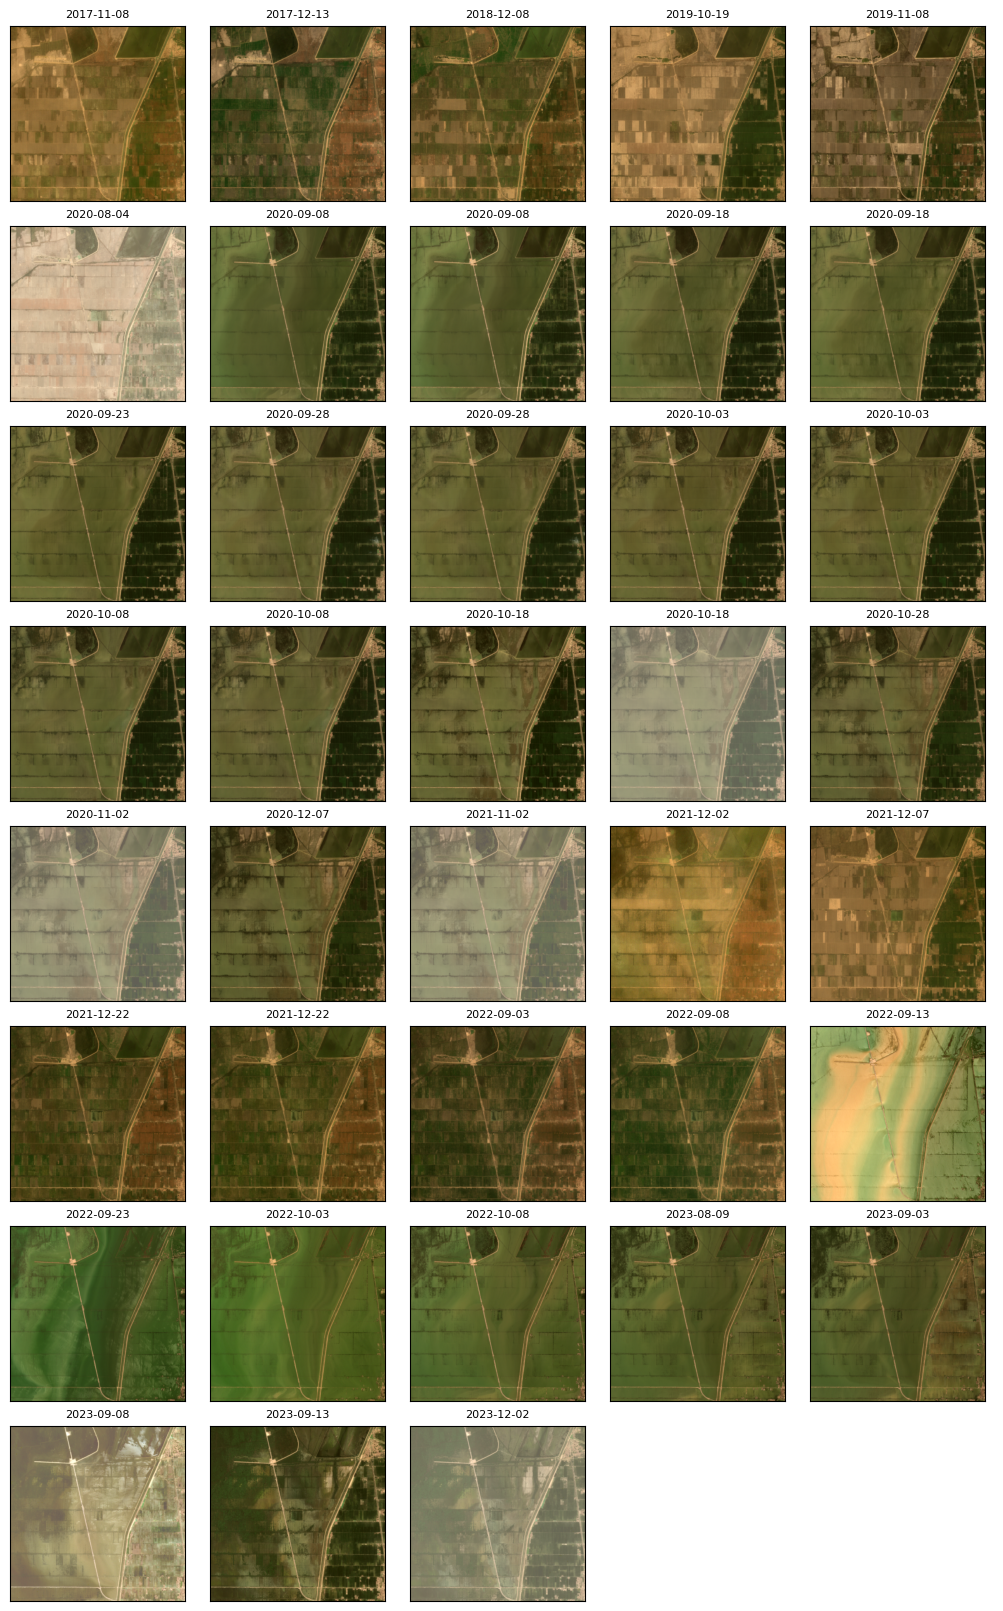

In [61]:
plt.close('all')

ncols = 5
nrows = int(math.ceil(len(dates_flood) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)

# dates_data_array = np.array([str(t.date()) for t in raster_source.data_array.time.to_series()])
ts = np.where([date in dates_flood for date in dates])[0]

with tqdm(zip(ts, dates_flood, axs.flat), total=len(ts)) as bar:
    for i, (t, date, ax) in enumerate(bar):
        chip_t = raster_sources_good[t][:, :]
        chip_t = (chip_t - chip_t.min()) / (chip_t.max() - chip_t.min())
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(date, fontsize=8)
if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()